# Using k-means clustering to discover discrepancies between the two counter-circulating beams of the Large Hadron Collider

4 kinds of analysis (k-means clustering, Euclidean distance, DBSCAN, Linear classifier) x 2 kinds of data (PCA, not PCA) x 4 beam modes (flat_top, start_ramp, start_adjust, start_squeeze)

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker # for spacing out Fill number labels on x-axis
import pandas as pd
import math
from sklearn.cluster import KMeans

## Load data


This data must be available before running this notebook.  Run the `Data collection.ipynb` notebook to create the data if it does not exist.

In [2]:
# Read saved ('pickled') DataFrames (result of Data collection notebook)
startRampLosses = pd.read_pickle("data/pickles/startRampLosses.pkl")
startAdjustLosses = pd.read_pickle("data/pickles/startAdjustLosses.pkl")
startSqueezeLosses = pd.read_pickle("data/pickles/startSqueezeLosses.pkl")
flatTopLosses = pd.read_pickle("data/pickles/flatTopLosses.pkl")

# lossesDfs = {
#     'start_ramp': pd.read_pickle("data/pickles/startRampLosses.pkl"),
#     'start_adjust': pd.read_pickle("data/pickles/startAdjustLosses.pkl"),
#     'start_squeeze': pd.read_pickle("data/pickles/startSqueezeLosses.pkl"),
#     'flat_top': pd.read_pickle("data/pickles/flatTopLosses.pkl")
# }

# OR
# lossesDfs = {
#     'start_adjust': (startAdjustLosses, startAdjustLossesPCA),
#     'flat_top': (flatTopLosses, flatTopLossesPCA),
#      ...
# }
# accessed: lossesDf['start_adjust'][0]
#           lossesDf['start_adjust'][1]
# or to iterate through:
# for name, df in dfs.items():
#

#TODO - maybe have just one losses variable, and read_pickle the different loss files manually (parameterising the notebook)

## Preprocessing

### Check variances, range

In [3]:
losses = flatTopLosses;  # change to any one of the other losses to compare (startRampLosses, startAdjustLosses, ...)

print("Std deviation\n")
print(losses.std().sort_values().head(1))
print(losses.std().sort_values().tail(1))
print("\nRange\n")
print((losses.max() - losses.min()).sort_values().head(1))
print((losses.max() - losses.min()).sort_values().tail(1))

Std deviation

TCL.6x1    1.225111e-07
dtype: float64
TCLA.A6x7    0.158534
dtype: float64

Range

TCL.6x1    7.043000e-07
dtype: float64
TCLA.A6x7    0.566399
dtype: float64


There is a large difference in order of magnitude in variance and range between the BLMs.  So that BLMs with high variance do not dominate the clustering and PCA calculations, we must standardise the values.

### Standardise data

According to https://maxwellsci.com/msproof.php?doi=rjaset.6.3638 standardisation is the most effective scaling technique before k-means.

TODO explain that Standardising is not just useful for k-means but also DBSCAN

TODO explain also that standardising is best before PCA (isn't it?) (as opposed to min-max etc.)

TODO compare clustering efficiency with robustscaler, min-max scaler

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

startRampLosses.loc[:] = scaler.fit_transform(startRampLosses.loc[:])
startSqueezeLosses.loc[:] = scaler.fit_transform(startSqueezeLosses.loc[:])
startAdjustLosses.loc[:] = scaler.fit_transform(startAdjustLosses.loc[:])
flatTopLosses.loc[:] = scaler.fit_transform(flatTopLosses.loc[:])

### Dimensionality reduction using PCA

In [5]:
from sklearn.decomposition import PCA

# pca = PCA()  # n_components not set => keep all components
# TODO print the explained variance ratio?  is it useful for the report?
# print('Explained variance ratio of each BLM (sums to 1):')
# pca.fit(startRampLosses)
# print(pca.explained_variance_ratio_)
# print(sum(pca.explained_variance_ratio_))

pca = PCA(n_components=3, whiten=True)
# From https://scikit-learn.org/stable/modules/decomposition.html#pca
# The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each 
# component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy 
# of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering 
# algorithm.
# I am using k-means clustering, and also DBSCAN, but not using the RBF kernel - using linear kernel for SVM.
# but I think this is also using Euclidean distance (to get best fit line / hyperplane) and therefore I think it is also
# assuming isotropy.
# TODO ask what "project the data onto the singular space" means.  and ask if agreed that whiten=True should be used.  
startRampLossesPCA = pd.DataFrame(data=pca.fit_transform(startRampLosses), index=startRampLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
startSqueezeLossesPCA = pd.DataFrame(data=pca.fit_transform(startSqueezeLosses), index=startSqueezeLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
startAdjustLossesPCA = pd.DataFrame(data=pca.fit_transform(startAdjustLosses), index=startAdjustLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])
flatTopLossesPCA = pd.DataFrame(data=pca.fit_transform(flatTopLosses), index=flatTopLosses.index, columns=['PCA1', 'PCA2', 'PCA3'])

Using PCA parameter `whiten=True`, we get unit variance.  This is useful for clustering algorithms (k-means, DBSCAN) that assume the signal is isotropic in all directions.

In [6]:
flatTopLossesPCA.std()

PCA1    1.0
PCA2    1.0
PCA3    1.0
dtype: float64

## Visualising the 3D PCA data

Helper function

In [7]:
def scatterPlotLosses(losses, title="", ax=None):
    noExistingAxes = (ax == None)

    if noExistingAxes:
        from mpl_toolkits.mplot3d import Axes3D
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    xs = losses.loc['B1'][losses.columns[0]]
    ys = losses.loc['B1'][losses.columns[1]]
    zs = losses.loc['B1'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c='red', label='B1')

    xs = losses.loc['B2'][losses.columns[0]]
    ys = losses.loc['B2'][losses.columns[1]]
    zs = losses.loc['B2'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c='black', label='B2')

    ax.set_title(title)
    ax.set_xlabel(losses.columns[0])
    ax.set_ylabel(losses.columns[1])
    ax.set_zlabel(losses.columns[2])
    ax.add_artist(ax.legend(framealpha=0.5, loc="lower left"))
    
    if noExistingAxes:
        plt.show()

Plotting

<IPython.core.display.Javascript object>


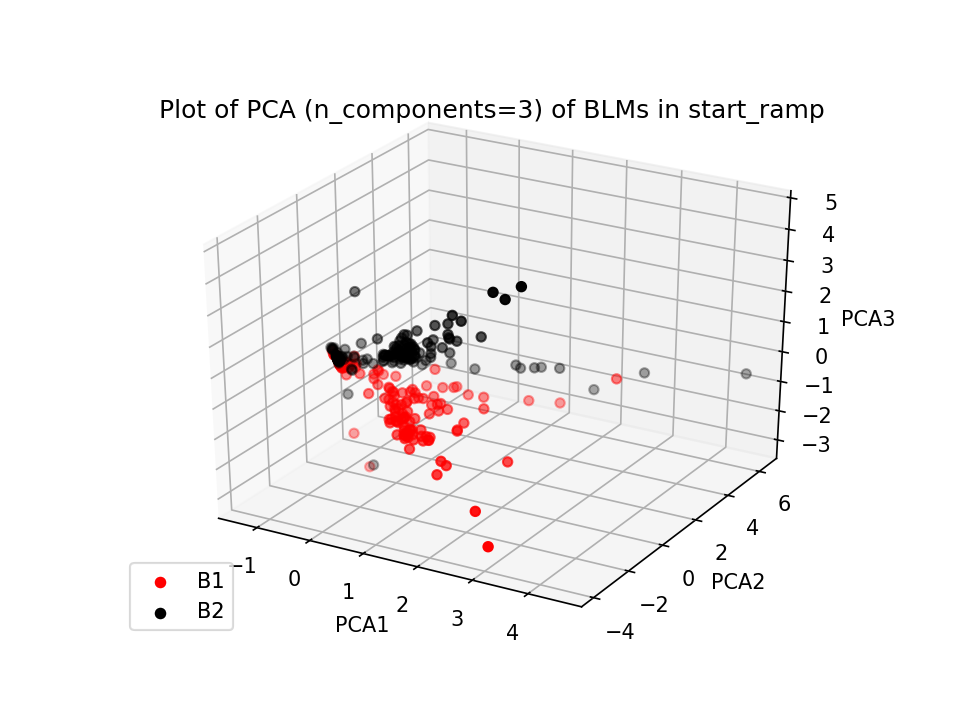

In [8]:
scatterPlotLosses(startRampLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_ramp")

<IPython.core.display.Javascript object>


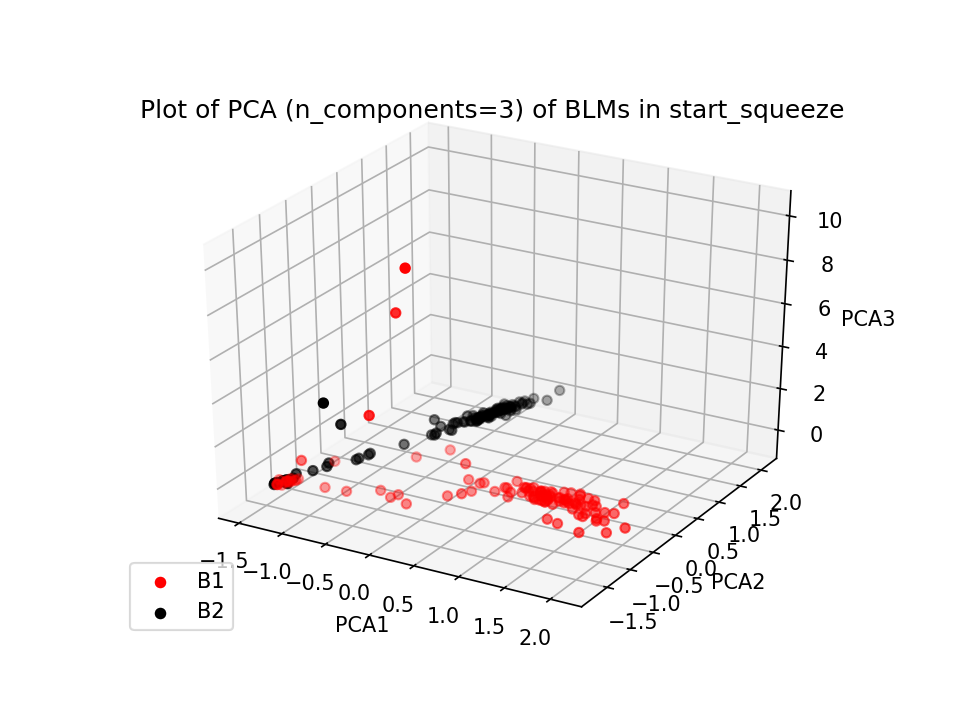

In [9]:
scatterPlotLosses(startSqueezeLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_squeeze")

<IPython.core.display.Javascript object>


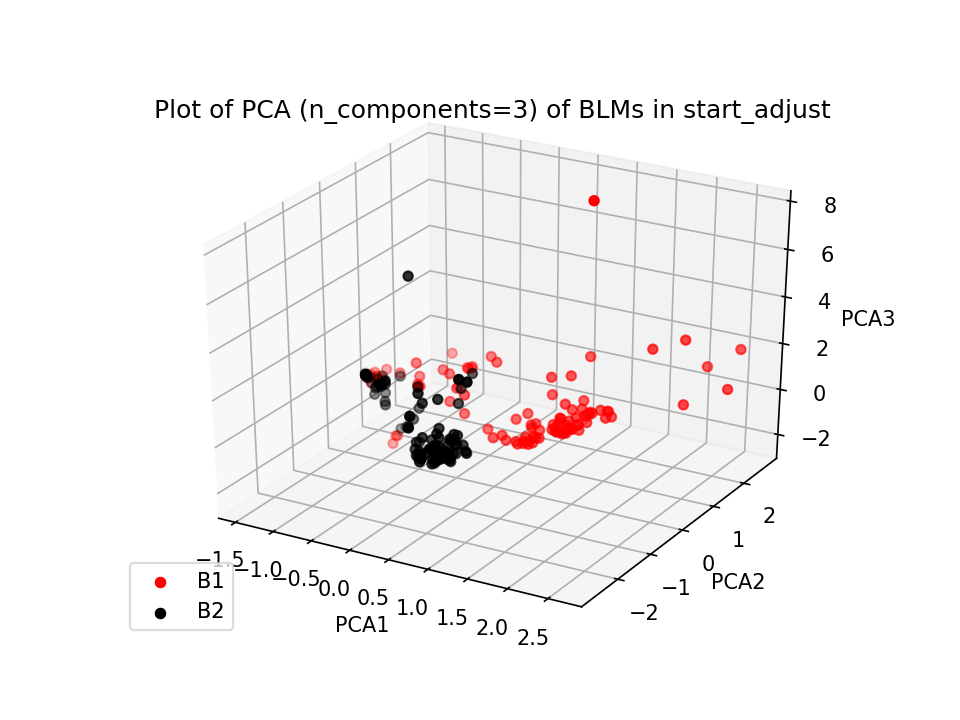

In [10]:
scatterPlotLosses(startAdjustLossesPCA, "Plot of PCA (n_components=3) of BLMs in start_adjust")

<IPython.core.display.Javascript object>


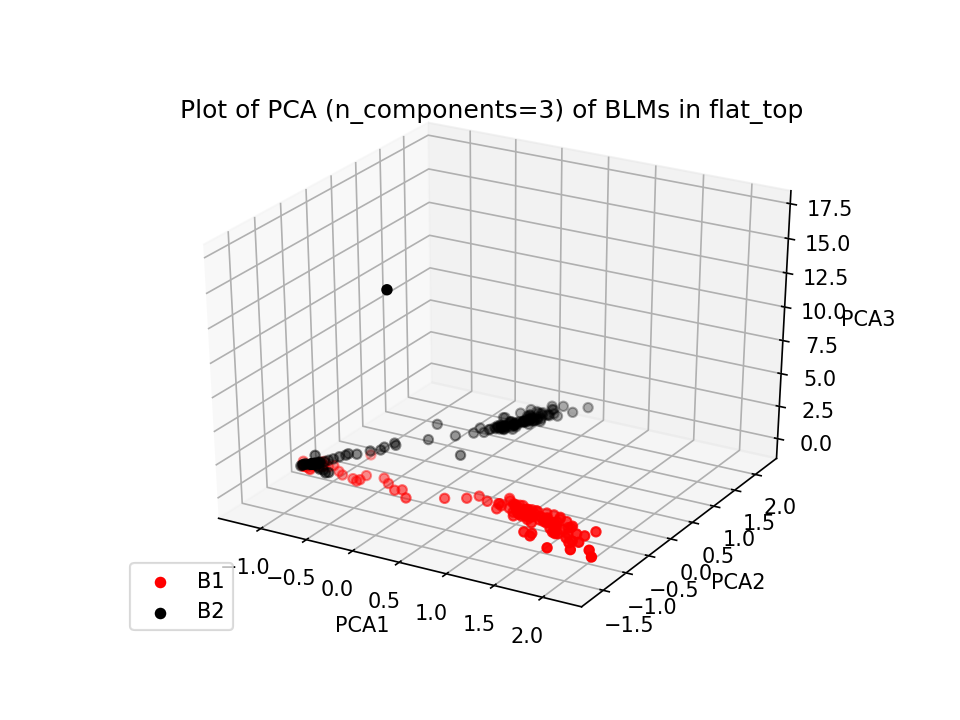

In [11]:
scatterPlotLosses(flatTopLossesPCA, "Plot of PCA (n_components=3) of BLMs in flat_top")

## KMeans clustering

### Helper functions

In [106]:
def compareKMeansWithGroundTruth(labels, losses):
    assert len(labels) == len(losses)
    
    overallAccuracy = 0

    for clusterNo in range(0, 2):  # loop through cluster 0, 1
        b1Count = 0
        b2Count = 0
        indicesOfLossesInCluster = np.where(labels == clusterNo)[0]
        lossesInClusterCount = len(indicesOfLossesInCluster)
                
        for key in losses.index.values[indicesOfLossesInCluster]:
            if key[0] == 'B1':
                b1Count = b1Count + 1
            elif key[0] == 'B2':
                b2Count = b2Count + 1
            else:
                print("Key error - neither B1 nor B2 in key {}".format(key))
                
        assert b1Count + b2Count == lossesInClusterCount
        
        proportionB1 = b1Count / lossesInClusterCount
        proportionB2 = b2Count / lossesInClusterCount
        
        print(f'\tCluster {clusterNo} has {(lossesInClusterCount / len(losses)):.2%} of the losses, of which:')
        print(f'\t\t\t{proportionB1:.2%} are B1, \t{proportionB2:.2%} are B2\n')
        
        if proportionB1 >= proportionB2:
            overallAccuracy += proportionB1
        else:
            overallAccuracy += proportionB2
    
    print(f'\tTherefore overall accuracy = {(overallAccuracy / 2):.2%}\n') # (accuracy of cluster 0 + of cluster 1) / 2
#         if b1Count <= b2Count:
#             print(f'\tCluster {clusterNo} is {(b2Count / lossesInClusterCount):%} B2 losses') # :.2% to set dec places
#         elif b1Count > b2Count:
#             print(f'\tCluster {clusterNo} is {(b1Count / lossesInClusterCount):%} B1 losses')

In [13]:
def scatterPlotClusters(losses, title="", labels=None):
    from mpl_toolkits.mplot3d import Axes3D
    
    assert len(losses) == len(labels)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # marker indicates ground truth, colour indicates cluster
    # TODO create proper legend for ground truth
    xs = losses.loc['B1'][losses.columns[0]]
    ys = losses.loc['B1'][losses.columns[1]]
    zs = losses.loc['B1'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c=labels[: len(labels)//2], marker='o')

    xs = losses.loc['B2'][losses.columns[0]]
    ys = losses.loc['B2'][losses.columns[1]]
    zs = losses.loc['B2'][losses.columns[2]]
    ax.scatter(xs, ys, zs, c=labels[len(labels)//2 :], marker='^')
    
    ax.set_xlabel(losses.columns[0])
    ax.set_ylabel(losses.columns[1])
    ax.set_zlabel(losses.columns[2])
    plt.title(title)
    plt.show()

In [14]:
def scatterPlotClusters2(losses, title="", labels=None):
    #TODO decide between scatterPlotClusters or scatterPlotClusters2 - I think method 2 is neater
    from mpl_toolkits.mplot3d import Axes3D
    
    assert len(losses) == len(labels)

    fig = plt.figure(figsize=plt.figaspect(0.5))  # make the figure half as tall as it is wide
    
    # Clusters subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title(title)
    scatter = ax.scatter(losses[losses.columns[0]], losses[losses.columns[1]], losses[losses.columns[2]],
               c=labels)
    ax.set_xlabel(losses.columns[0])
    ax.set_ylabel(losses.columns[1])
    ax.set_zlabel(losses.columns[2])
    
    ax.add_artist(ax.legend(*scatter.legend_elements(), title="Clusters", loc="lower left", framealpha=0.5))
    
    # Ground truth subplot
    scatterPlotLosses(losses, "Ground truth", fig.add_subplot(1, 2, 2, projection='3d'))
    
    plt.show()

In [108]:
def kmeansAnalysis(kmeans, losses, lossesPCA, phaseName):
    # clustering results = [] (array label arrays)
    # do clustering 5 times
    # if clustering result = first clustering result with cluster labels inverted, then these are the same
    #     so do not add to clustering results
    # else,
    # 
    print(f"{phaseName}\n")
    
    print('Full feature-space')
    labels = kmeans.fit_predict(losses)
    compareKMeansWithGroundTruth(labels, losses)
    print('\nPCA')
    labelsPCA = kmeans.fit_predict(lossesPCA)
    compareKMeansWithGroundTruth(labelsPCA, lossesPCA)
    
    scatterPlotClusters2(lossesPCA, f"k-means clusters of {phaseName}", labelsPCA)

### Analysis

In [16]:
kmeans = KMeans(n_clusters = 2)

flat_top

Full feature-space
	Cluster 0 has 30.13% of the losses, of which:
			98.90% are B1, 	1.10% are B2

	Cluster 1 has 69.87% of the losses, of which:
			28.91% are B1, 	71.09% are B2

	Therefore overall accuracy = 85.00%


PCA
	Cluster 0 has 99.67% of the losses, of which:
			50.17% are B1, 	49.83% are B2

	Cluster 1 has 0.33% of the losses, of which:
			0.00% are B1, 	100.00% are B2

	Therefore overall accuracy = 75.08%



<IPython.core.display.Javascript object>


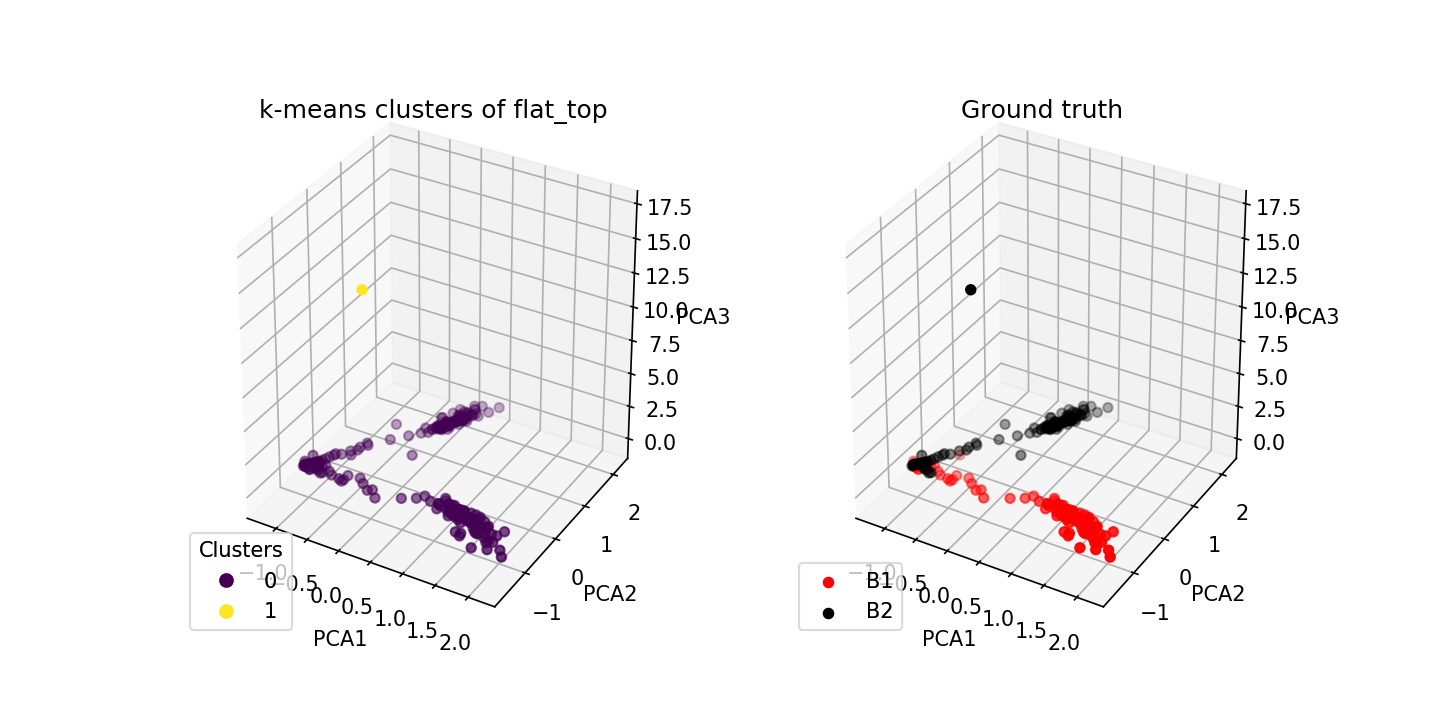

In [109]:
kmeansAnalysis(kmeans, flatTopLosses, flatTopLossesPCA, "flat_top")

start_ramp

	Full feature-space
	Cluster 0 has 57.62% of the losses, of which:
			50.57% B1 	49.43% B2
	Cluster 1 has 42.38% of the losses, of which:
			49.22% B1 	50.78% B2

	PCA
	Cluster 0 has 23.18% of the losses, of which:
			98.57% B1 	1.43% B2
	Cluster 1 has 76.82% of the losses, of which:
			35.34% B1 	64.66% B2


<IPython.core.display.Javascript object>


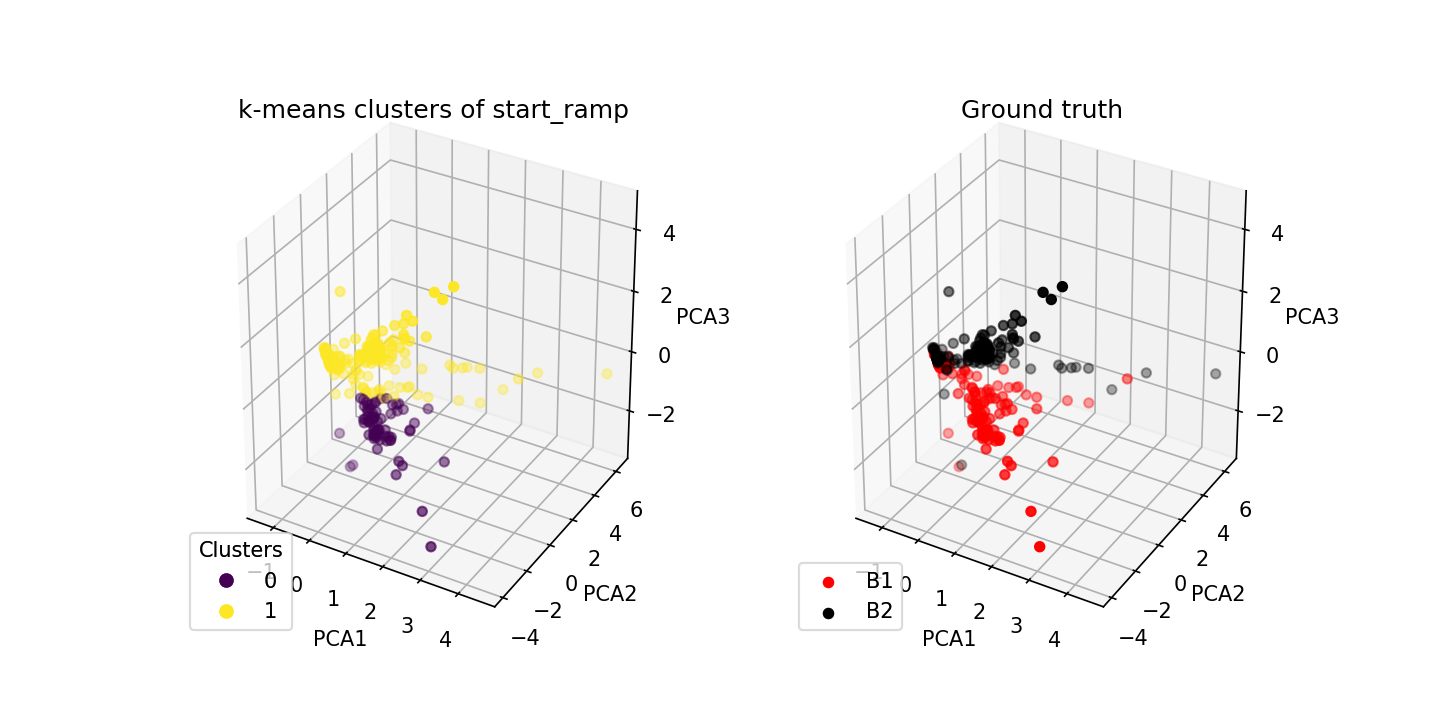

In [84]:
kmeansAnalysis(kmeans, startRampLosses, startRampLossesPCA, "start_ramp")

start_squeeze

	Full feature-space
	Cluster 0 has 63.04% of the losses, of which:
			20.69% B1 	79.31% B2
	Cluster 1 has 36.96% of the losses, of which:
			100.00% B1 	0.00% B2

	PCA
	Cluster 0 has 37.83% of the losses, of which:
			0.00% B1 	100.00% B2
	Cluster 1 has 62.17% of the losses, of which:
			80.42% B1 	19.58% B2


<IPython.core.display.Javascript object>


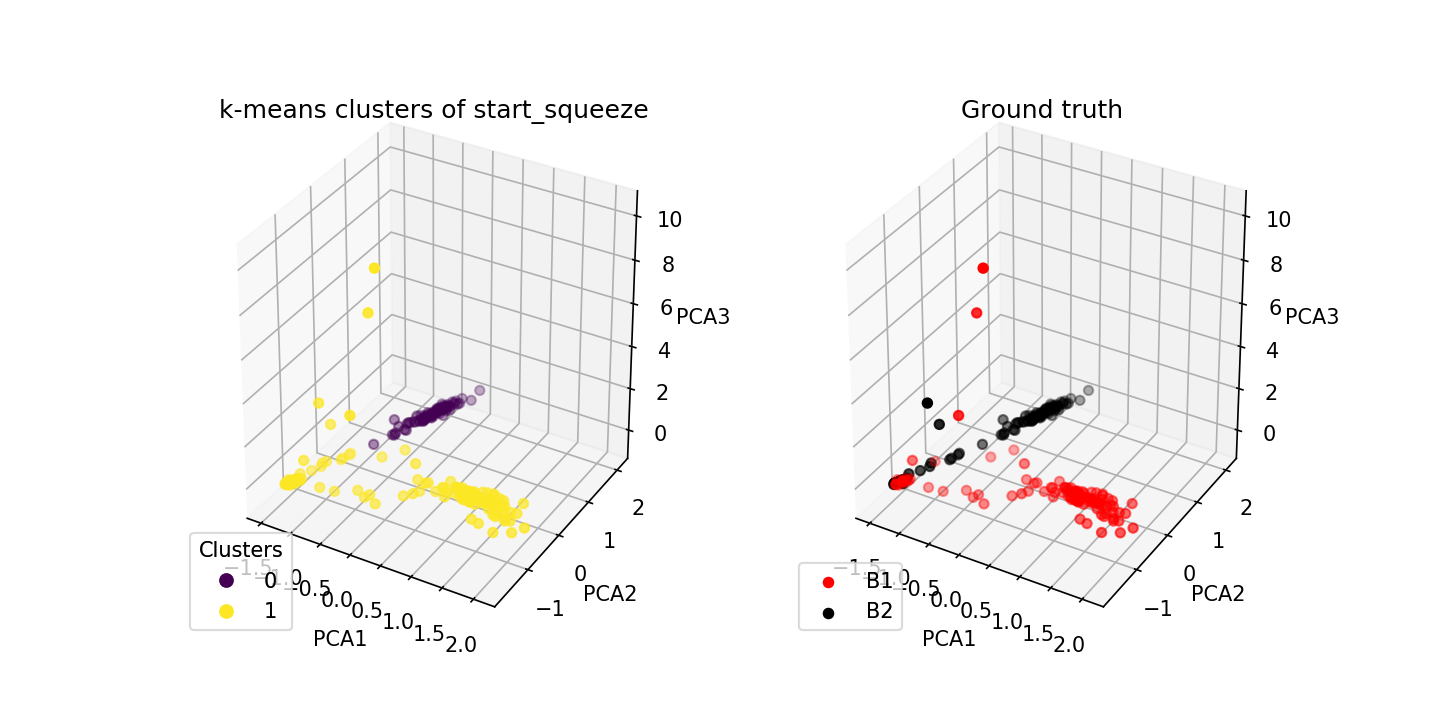

In [87]:
kmeansAnalysis(kmeans, startSqueezeLosses, startSqueezeLossesPCA, "start_squeeze")

start_adjust

	Full feature-space
	Cluster 0 has 59.17% of the losses, of which:
			50.70% B1 	49.30% B2
	Cluster 1 has 40.83% of the losses, of which:
			48.98% B1 	51.02% B2

	PCA
	Cluster 0 has 41.67% of the losses, of which:
			51.00% B1 	49.00% B2
	Cluster 1 has 58.33% of the losses, of which:
			49.29% B1 	50.71% B2


<IPython.core.display.Javascript object>


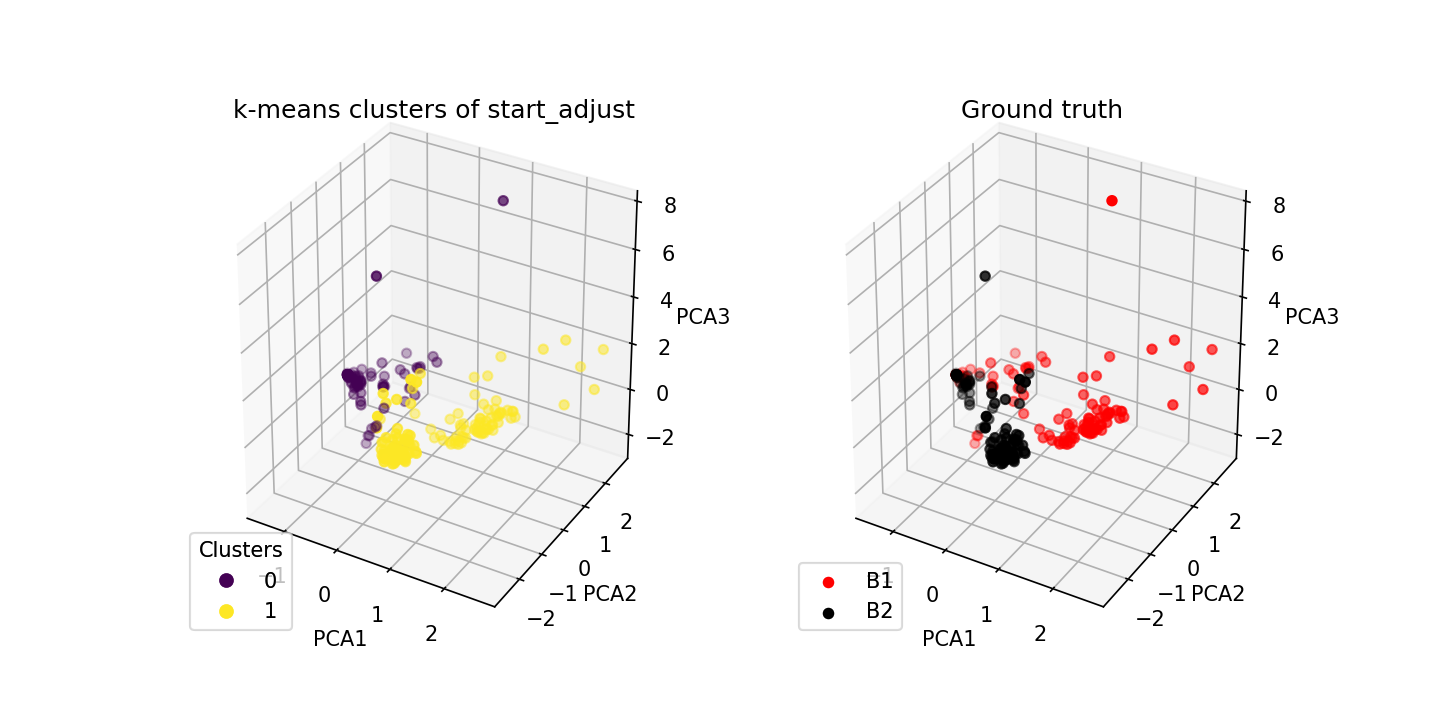

In [89]:
kmeansAnalysis(kmeans, startAdjustLosses, startAdjustLossesPCA, "start_adjust")

## DBSCAN



### Helper functions

In [21]:
def dbscanAnalysis(dbscan, lossesPCA, phaseName):
    labelsPCA = dbscan.fit_predict(lossesPCA)
    scatterPlotClusters2(lossesPCA, f"DBSCAN clusters of {phaseName}", labelsPCA)

### Analysis

In [22]:
#TODO move imports to topmost cell?  eg. kmeans import is in topmost cell
from sklearn.cluster import DBSCAN
# eps - "The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not
#        a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose 
#        appropriately for your data set and distance function."
# min_samples - "The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
#                This includes the point itself."

# min samples: can go from 5% of the data set size up to 30%.  
# don't forget this is a MINIMUM. it's not THE number of points in each cluster
# -- Do a loop, try out differnt vslues of min neighbours

# eps: after doing scaling, print out the max and min in the dataframe.  
#     will give indication of eps.  or choose eps to match ground truth.
# ? what is eps ground truth?

dbscan = DBSCAN(eps=0.5, min_samples=15) # these params worked when PCA whiten=True
                                        # if whiten=False, try eps=1, min_samples=6 and eps=1.4, min=15 - 5% of startRamp len
                                        # looks like if min_samples goes up, eps must also ... otherwise we are expecting
        # a very dense neighbourhood for a point to be a core point if we have a small eps (radius) and a high min_samples.
        # eg. eps=0.3, min_samples=6 worked (PCA whiten=True).  but boosting min_samples to 15, I also boosted eps to 0.5
        # and this gave me the "nicest" result yet
# from Wikipedia = as a rule of thumb, 2*dimensions (2*3 = 6) can be used

does dbscan tell you that there are multiple classes?  two classes?  1 class?

<IPython.core.display.Javascript object>


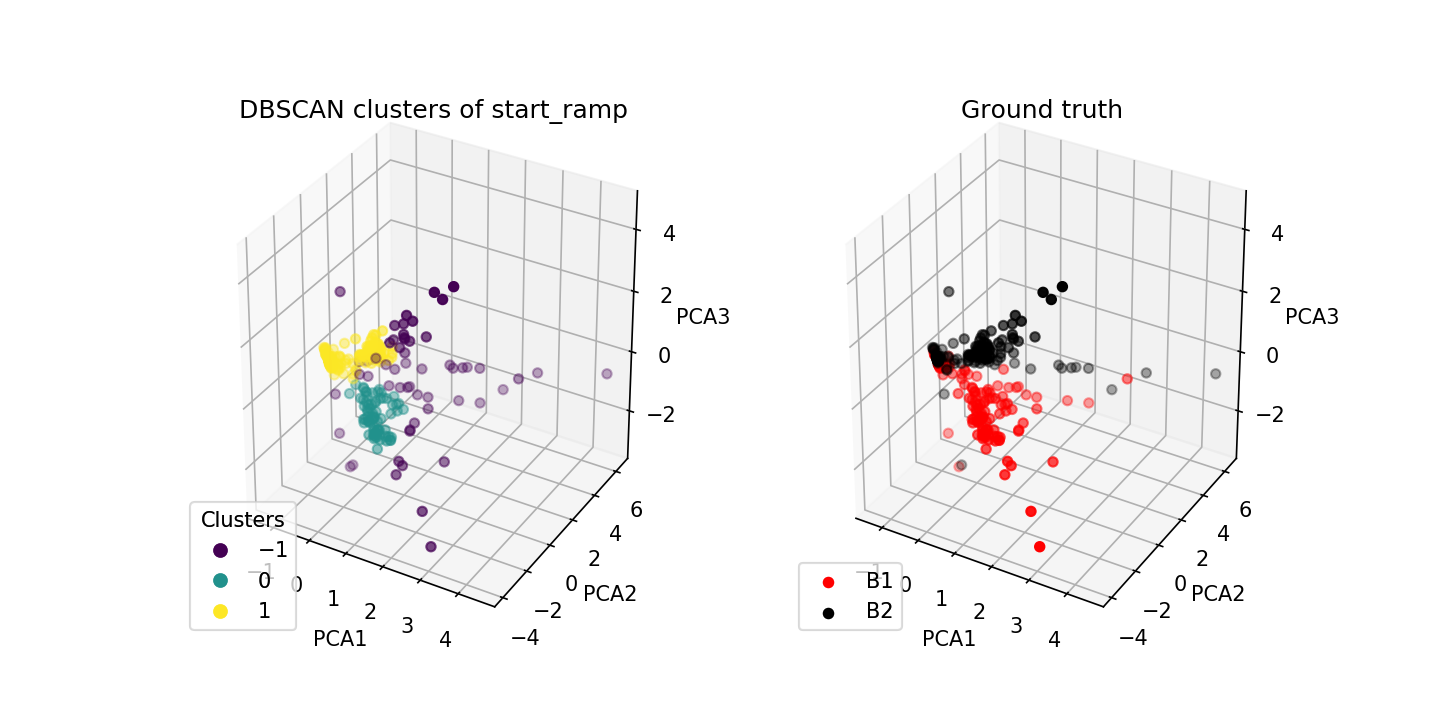

In [23]:
dbscanAnalysis(dbscan, startRampLossesPCA, "start_ramp")

<IPython.core.display.Javascript object>


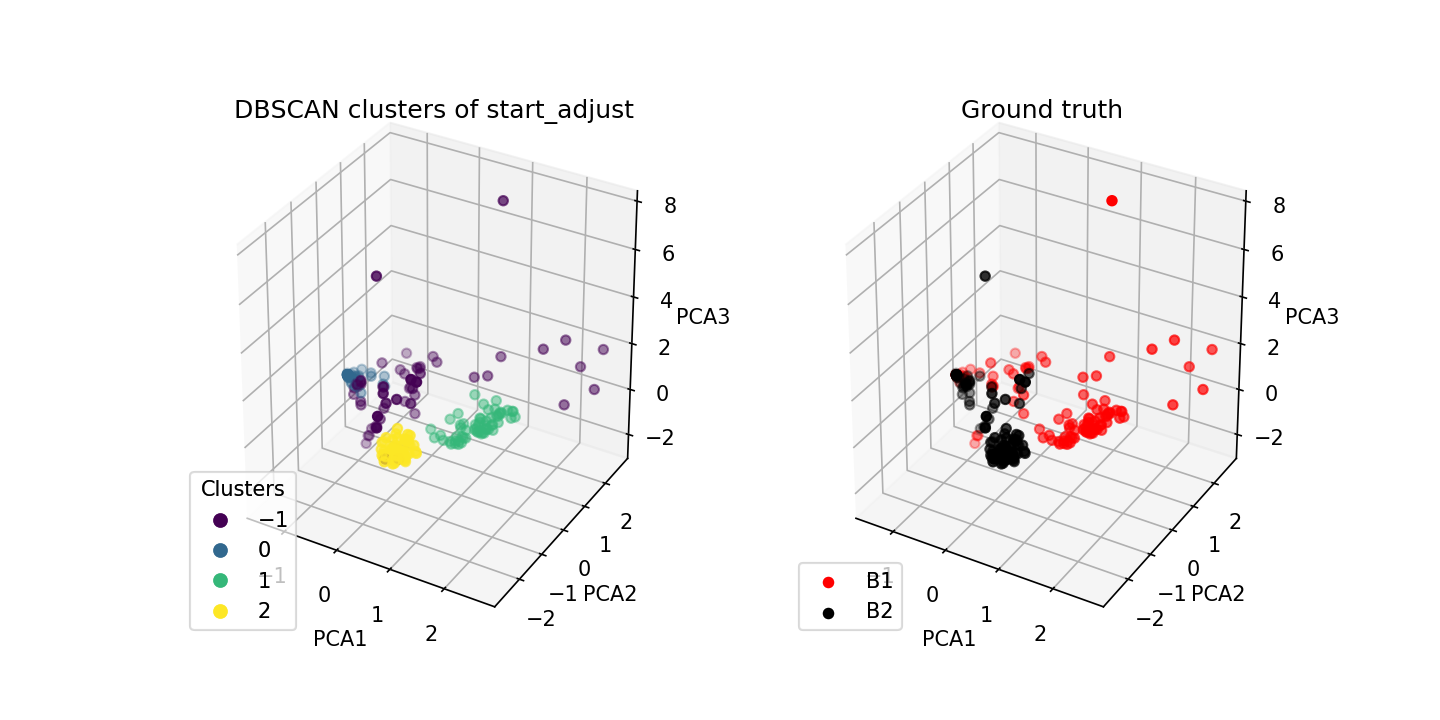

In [24]:
dbscanAnalysis(dbscan, startAdjustLossesPCA, "start_adjust")

<IPython.core.display.Javascript object>


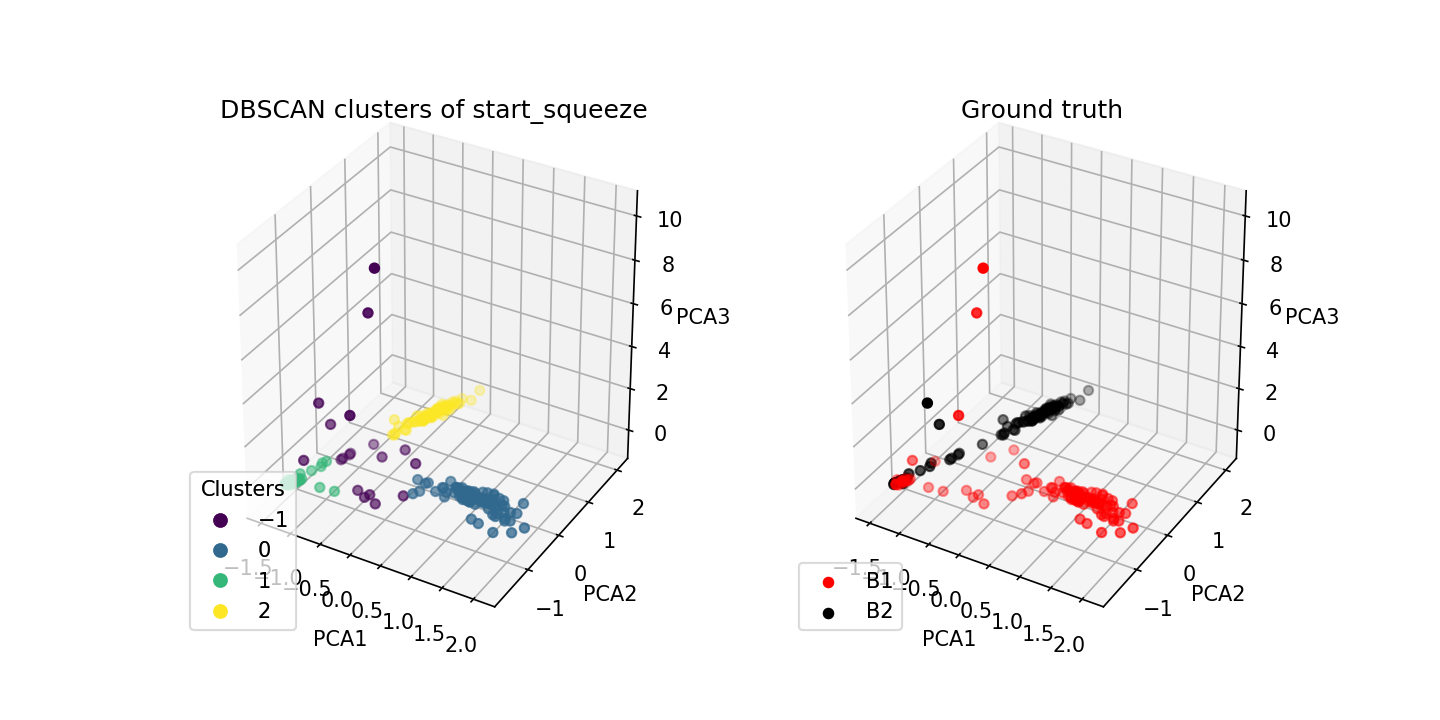

In [25]:
dbscanAnalysis(dbscan, startSqueezeLossesPCA, "start_squeeze")

<IPython.core.display.Javascript object>


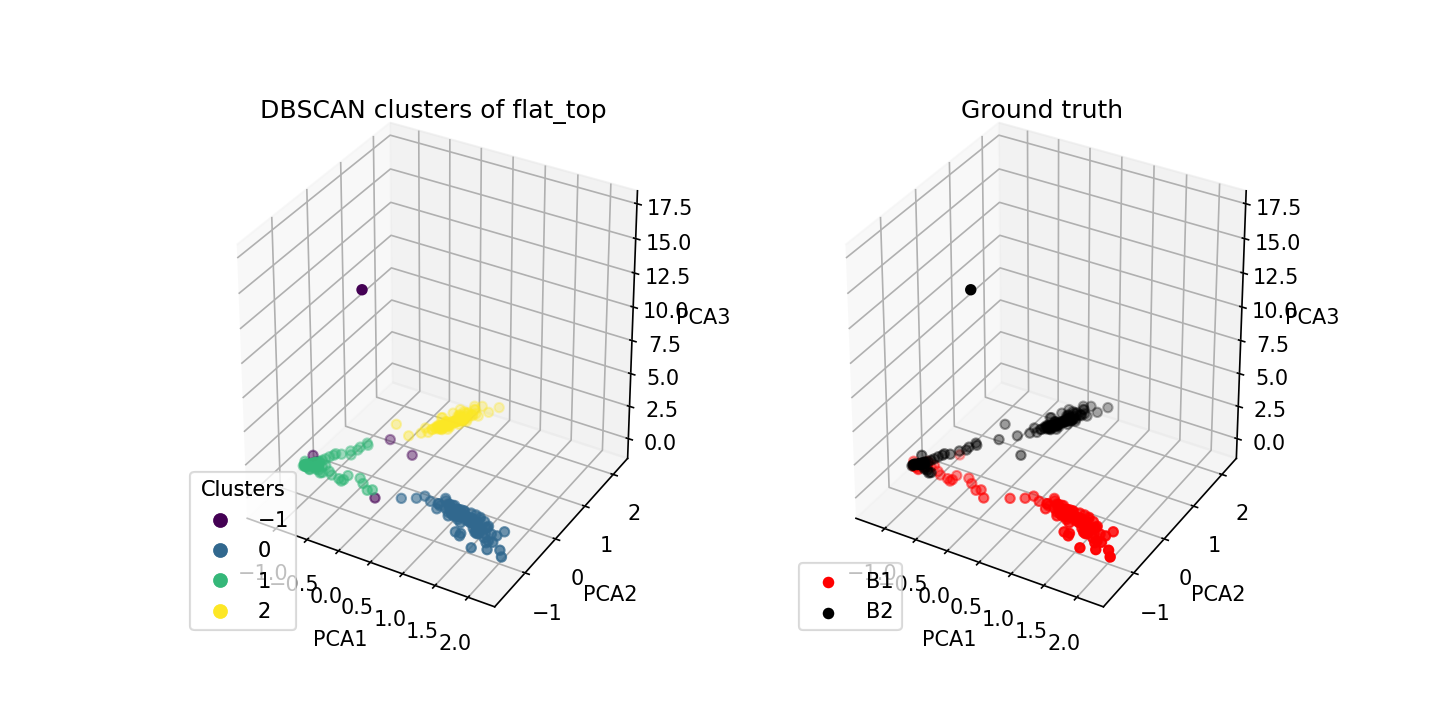

In [26]:
dbscanAnalysis(dbscan, flatTopLossesPCA, "flat_top")

## Euclidean distance

### Helper functions

To get Euclidean distance between the BLM vectors for beam 1 and beam 2

In [27]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

def getEuclideanDistance(losses):
    return pd.Series(cdist(losses.loc['B1'].values, losses.loc['B2'].values, metric='euclidean').diagonal(),
                     index=losses.loc['B1'].index) # to preserve the fill numbers for x-axis of the euclidean distance plot

# getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
# ie. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
# row 1 of B2 values, and so on.

# to confirm values are correct:
# print(distance)
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[0], mergedPhaseLosses.loc['B2'].iloc[0]))
# print(euclidean(mergedPhaseLosses.loc['B1'].iloc[1], mergedPhaseLosses.loc['B2'].iloc[1]))
# ...

### Analysis

<IPython.core.display.Javascript object>


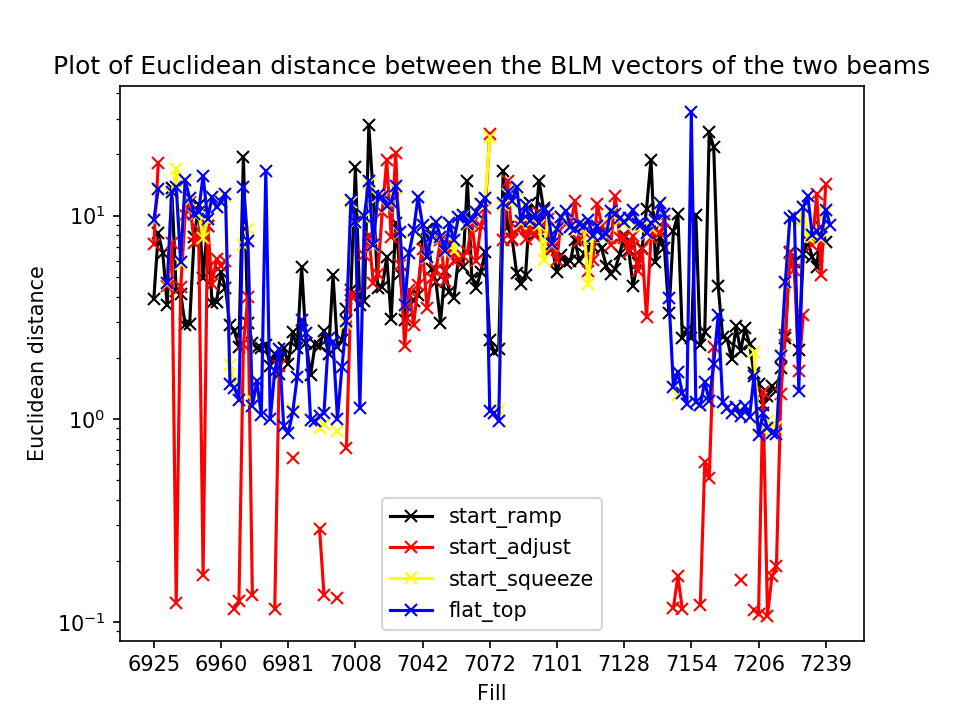

In [28]:
df = pd.DataFrame({
    'start_ramp': getEuclideanDistance(startRampLosses),
    'start_adjust': getEuclideanDistance(startAdjustLosses),
    'start_squeeze': getEuclideanDistance(startSqueezeLosses),
    'flat_top': getEuclideanDistance(flatTopLosses)
})

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot('start_ramp', data=df, marker='x', color='black')
ax.plot('start_adjust', data=df, marker='x', color='red')
ax.plot('start_squeeze', data=df, marker='x', color='yellow')
ax.plot('flat_top', data=df, marker='x', color='blue')
ax.set(xlabel='Fill',
       ylabel='Euclidean distance',
       title='Plot of Euclidean distance between the BLM vectors of the two beams')
ax.legend()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

# TODO repeat for PCA

## Linear classifier

Here we deliberately use linear classifiers because we are interested in finding asymmetry if it exists.  The worse the classifier does at linearly separating the data, the more symmetric the data.  The better the classisfier does at linearly separating the data, the more asymmetric the data.

### Helper functions

In [29]:
def plotClassifierPlane(lossesPCA, phaseName, clf):
    # Note: https://matplotlib.org/mpl_toolkits/mplot3d/faq.html#my-3d-plot-doesn-t-look-right-at-certain-viewing-angles
    #"This is probably the most commonly reported issue with mplot3d. The problem is that – from some viewing angles – a 
    #3D object would appear in front of another object, even though it is physically behind it."

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatterPlotLosses(lossesPCA, f"Linear SVC decision plane on {phaseName}", ax)
    
    # ax.plot_surface([0,0], [1,1], [1,1])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
#     zlim = ax.get_zlim() - for having same scale on axes as original plot (before adding the surface)
    x, y = np.meshgrid(np.linspace(xlim[0], xlim[1], 2),
                         np.linspace(ylim[0], ylim[1], 2))
    z = lambda x, y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]
    
#     ax.set_zlim(zlim) - for having same scale on axes as original plot (before adding the surface)
    ax.plot_surface(x, y, z(x,y), alpha=0.9)

In [30]:
def linearClassifierAnalysis(clf, lossesPCA, phaseName):
    samplesCount = len(lossesPCA)
    
    # make ground truth labels used by the linear classifier - where each element of the list corresponds to a row
    #     1 means the corresponding row is a B1 loss
    #     2 means the corresponding row is a B2 loss
    classes = ([1] * (samplesCount // 2)) + ([2] * (samplesCount // 2))

    # test that class 1 corresponds to 'B1' index in the dataframe, class 2 corresponds to 'B2'
    for idx, c in enumerate(classes):
        assert (c == 1 and lossesPCA.iloc[idx].name[0] == 'B1') or (c == 2 and lossesPCA.iloc[idx].name[0] == 'B2')

    clf.fit(lossesPCA, classes)
    plotClassifierPlane(lossesPCA, phaseName, clf)

### Analysis

In [31]:
from sklearn import svm
clf = svm.LinearSVC(dual=False) # docs: "Prefer dual=False when n_samples > n_features"
#TODO ask - should you standardise before SVM?
#I think so: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
#A Practical Guide to Support Vector CLassification: The main advantage of scaling is to avoid attributes in greater numeric
#ranges dominating those in smaller numeric ranges. Another advantage is to avoid numerical diculties during the calculation. 
#Because kernel values usually depend on the inner products of feature vectors, e.g. the linear kernel and the polynomial 
#ker- nel, large attribute values might cause numerical problems. We recommend linearly scaling each attribute to the range 
#[-1,+1] or [0,1].
# TODO ask about this - the authors are recommending to scale linearly but I have standardised (i.e. changing the distribution
# to unit variance, zero mean.)

<IPython.core.display.Javascript object>


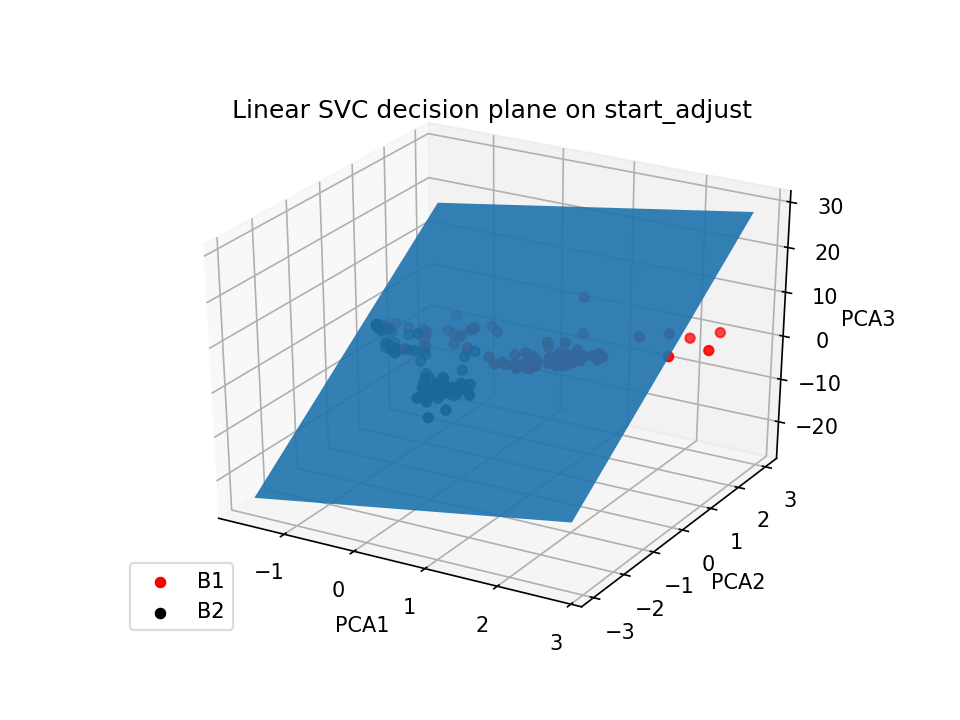

In [32]:
linearClassifierAnalysis(clf, startAdjustLossesPCA, 'start_adjust')

<IPython.core.display.Javascript object>


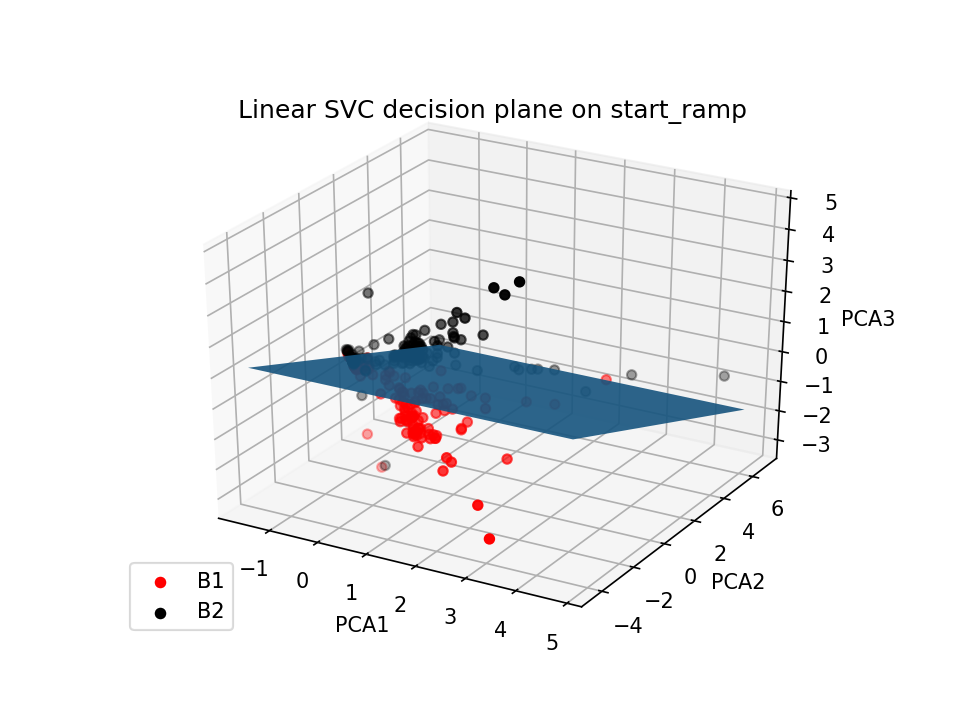

In [33]:
linearClassifierAnalysis(clf, startRampLossesPCA, 'start_ramp')

<IPython.core.display.Javascript object>


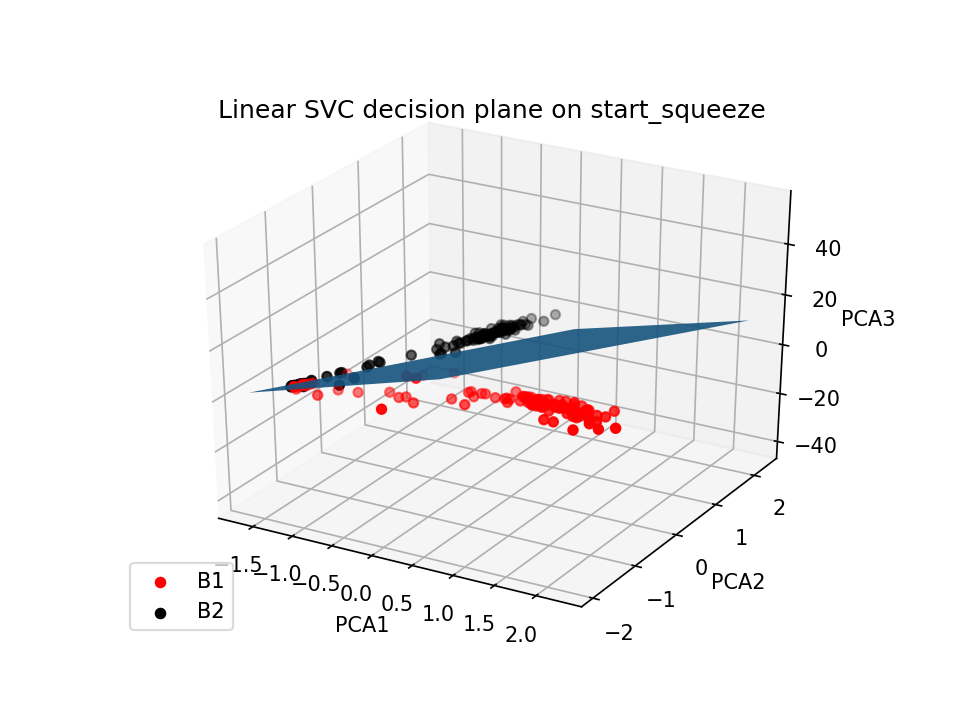

In [34]:
linearClassifierAnalysis(clf, startSqueezeLossesPCA, 'start_squeeze')

<IPython.core.display.Javascript object>


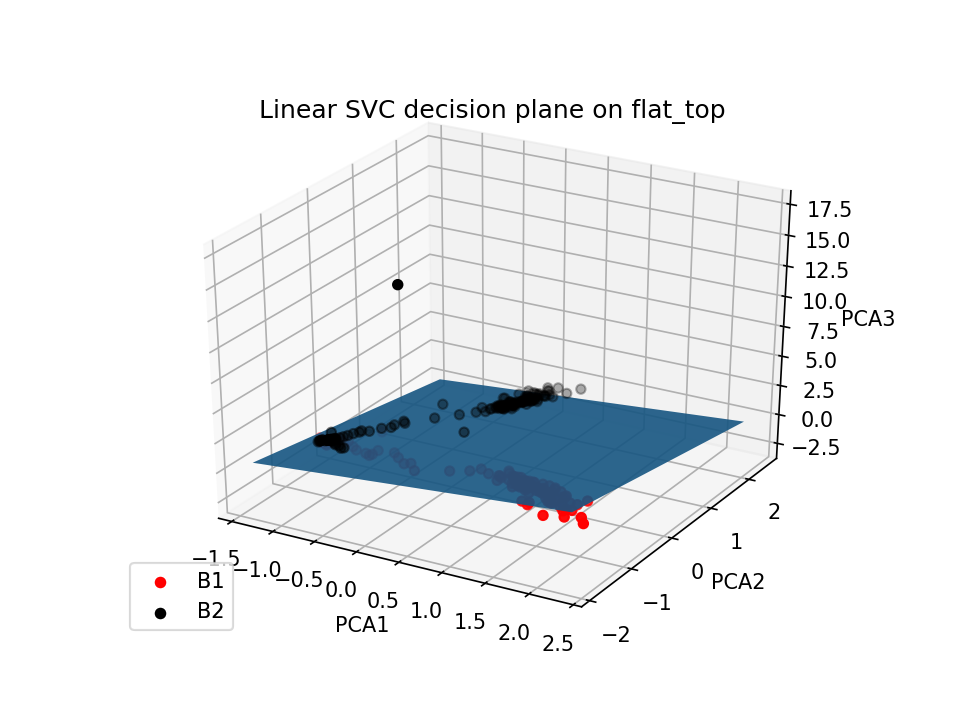

In [35]:
linearClassifierAnalysis(clf, flatTopLossesPCA, 'flat_top')

## Exploratory plots

<IPython.core.display.Javascript object>


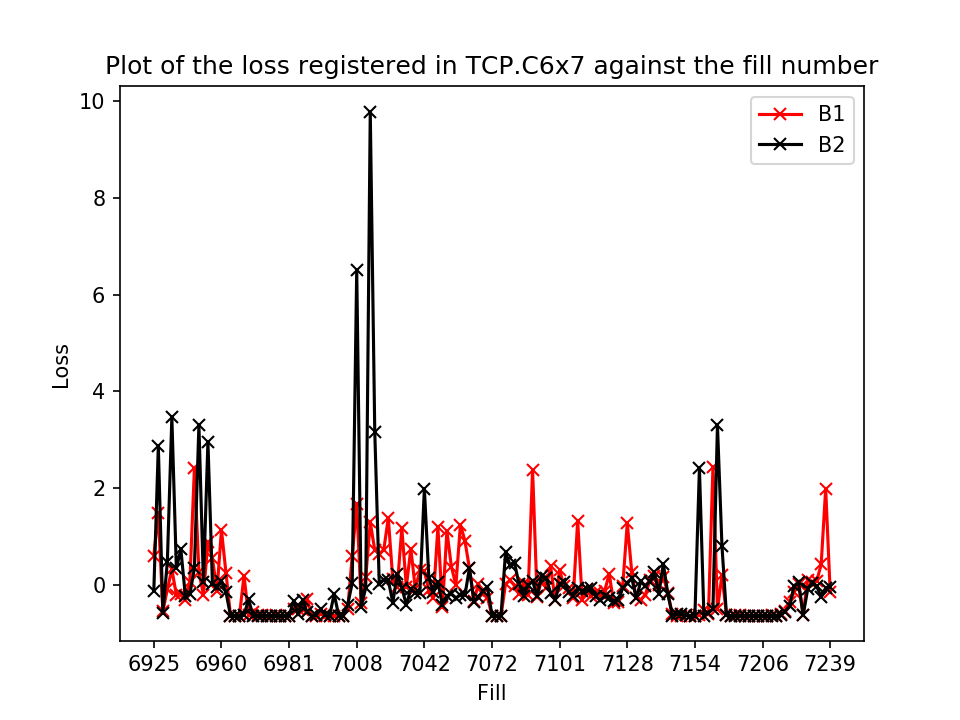

In [36]:
# Data
df = pd.DataFrame({
    'B1': startRampLosses.loc['B1']['TCP.C6x7'],
    'B2': startRampLosses.loc['B2']['TCP.C6x7']
})
 
# multiple line plot
fig, ax = plt.subplots()
ax.plot('B1', data=df, marker='x', color='red')
ax.plot('B2', data=df, marker='x', color='black')
ax.set(xlabel='Fill', ylabel='Loss', title='Plot of the loss registered in TCP.C6x7 against the fill number')
ax.legend()
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

In [37]:
# plt.figure(figsize=(10, 36))
# ncols = 3;
# nrows = math.ceil(startRampLosses.shape[1] / ncols)
# i = 1;
# for column in startRampLosses:
#     # Data
#     df = pd.DataFrame({
#         'B1': startRampLosses.loc['B1'][column],
#         'B2': startRampLosses.loc['B2'][column]
#     })
 
#     plt.subplot(nrows, ncols, i)
# #     plt.yscale('log') # TODO - ask: no need for log scale since we have standardised the data now?
# #     plt.yscale('symlog') - since we have negative values now after standardising
#     plt.plot('B1', data=df, marker='x', color='red')
#     plt.plot('B2', data=df, marker='x', color='black')
#     plt.title(column)

    
#     i = i + 1
    

# plt.tight_layout()